In [ ]:
# #Saving to csv the dowload THis works but do not dowload mutiple times
# import yfinance as yf
# import pandas as pd

# # Define the ticker symbol and the start date
# ticker_symbol = "TSLA"
# start_date = "2020-01-01"
# csv_filename = "tesla_daily_data_2020_onwards.csv"

# try:
#     # Download Tesla stock data
#     print(f"Downloading {ticker_symbol} data from {start_date} to latest...")
#     tesla_data = yf.download(ticker_symbol, start=start_date)

#     if tesla_data.empty:
#         print(f"No data found for {ticker_symbol} from {start_date}.")
#     else:
#         # Save the data to CSV. The index (Date) will be saved automatically.
#         tesla_data.to_csv(csv_filename)
#         print(f"Successfully downloaded Tesla (TSLA) daily data and saved to {csv_filename}")
#         print("\nFirst 5 days of downloaded data:")
#         print(tesla_data.head())
#         print("\nLast 5 days of downloaded data:")
#         print(tesla_data.tail())

# except Exception as e:
#     print(f"An error occurred during download or saving: {e}")

In [3]:
df

,Price,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500.0
2020-01-03,2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500.0
2020-01-06,2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000.0
2020-01-07,2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500.0
2020-01-08,2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500.0
...,...,...,...,...,...,...
2025-05-07,2025-05-07,276.220001,277.920013,271.000000,276.880005,71592600.0
2025-05-08,2025-05-08,284.820007,289.799988,279.410004,279.630005,97539400.0
2025-05-09,2025-05-09,298.260010,307.040009,290.000000,290.209991,132387800.0



--- ADF Test on Close series ---
ADF stat = -2.634, p-value = 0.086

--- Running auto_arima (d=1, D=1, m=8) ---
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1399
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 8)   Log Likelihood               -5351.125
Date:                           Thu, 15 May 2025   AIC                          10708.249
Time:                                   22:28:06   BIC                          10723.961
Sample:                               01-02-2020   HQIC                         10714.125
                                    - 05-13-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept

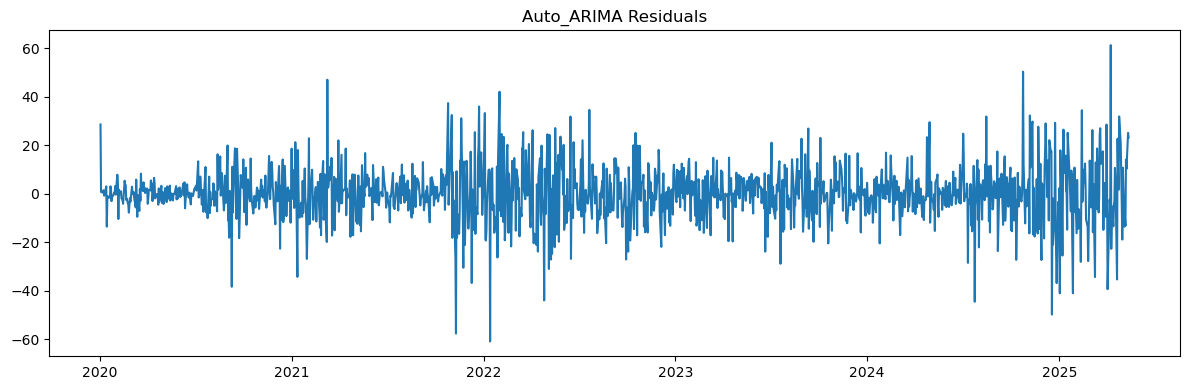

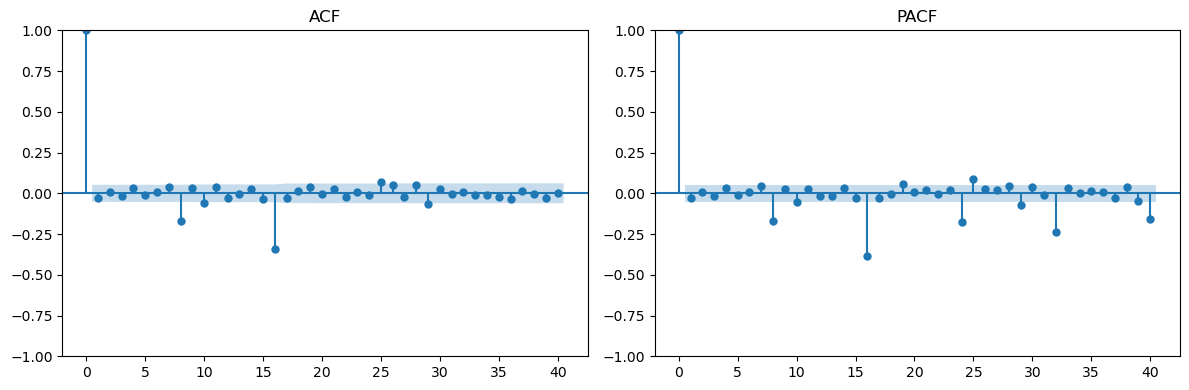


Ljung-Box (lag 20):
        lb_stat     lb_pvalue
20  228.000187  3.007049e-37 

--- Forecasting next 30 business days ---


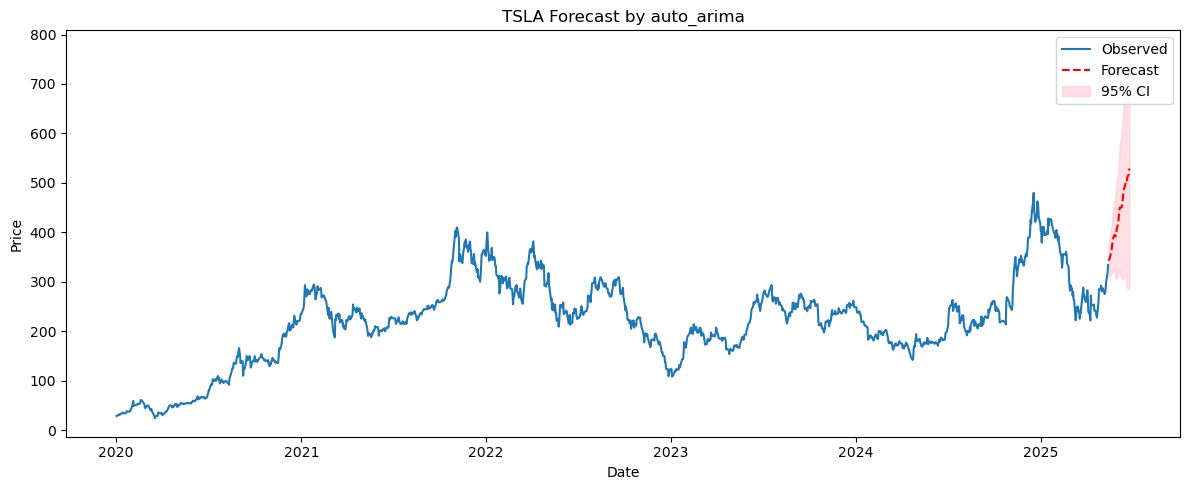

--- Simulating 1000 paths for 30 steps ---


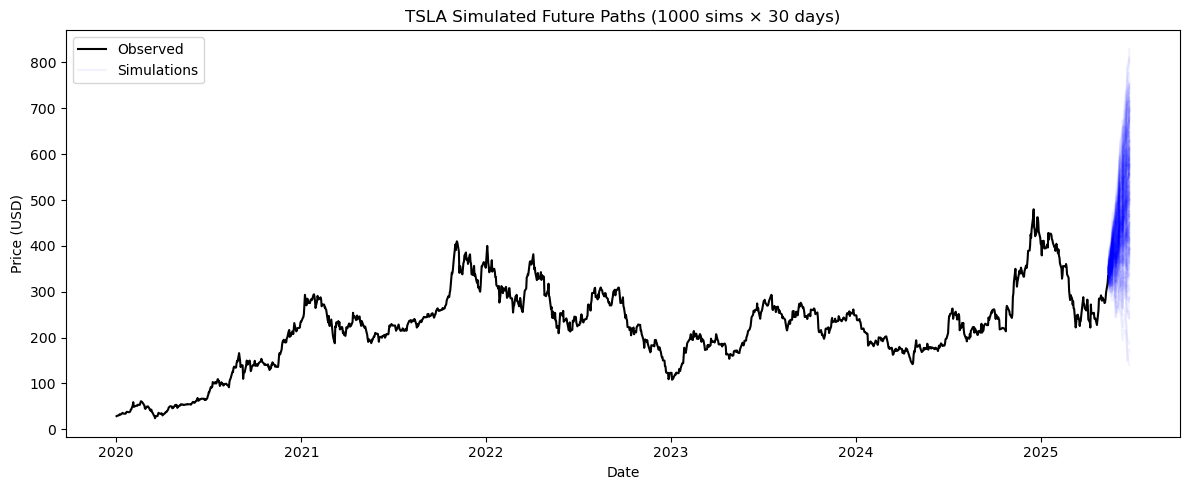


Proportion analysis of simulated final prices after 30 steps:
  Proportion ending above model end price ($334.07): 0.948
  Proportion ending below model end price ($334.07): 0.052
  Ratio up/down relative to model end price: 18.23

Summary statistics of simulated final prices after 30 steps:
  Mean simulated final price:       $529.72
  Median simulated final price:     $524.77
  Lower Quartile (25th percentile): $445.02
  Upper Quartile (75th percentile): $613.06

Load with Calls -> direction is UP


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import BDay

import pmdarima as pm

# ------------------------------------------------------------------
# 0. User settings
# ------------------------------------------------------------------
CSV_FILE       = "tesla_daily_data_2020_onwards.csv"
START_DATE     = "2020-01-01"
END_DATE       = "2025-05-13"
M              = 8              # seasonal period (8 business days)
N_STEPS        = 30            # forecast horizon
N_SIMS         = 1000           # number of simulation paths

# ------------------------------------------------------------------
# 1. LOAD & PREPARE data
# ------------------------------------------------------------------
df = (
    pd.read_csv(CSV_FILE, skiprows=[1,2])
      .assign(Date=lambda d: pd.to_datetime(d['Price'], errors='coerce'),
              Close=lambda d: pd.to_numeric(d['Close'], errors='coerce'))
      .dropna(subset=['Date','Close'])
      .set_index('Date')
      .sort_index()
)

# restrict to business days & forward-fill any missing
df = df.asfreq('B').ffill().loc[START_DATE:END_DATE]
close = df['Close']
dates = close.index

# ------------------------------------------------------------------
# 2. STATIONARITY TEST (ADF)
# ------------------------------------------------------------------
print("\n--- ADF Test on Close series ---")
stat, pval, *_ = adfuller(close)
print(f"ADF stat = {stat:.3f}, p-value = {pval:.3f}\n")

# ------------------------------------------------------------------
# 3. AUTO_ARIMA SEARCH (force d=1, D=1, m=8, allow drift)
# ------------------------------------------------------------------
print(f"--- Running auto_arima (d=1, D=1, m={M}) ---")
auto_mod = pm.auto_arima(
    close,
    d=1, D=1, m=M,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    seasonal=True,
    trend='c',              # intercept→drift in Δy
    stepwise=True,          # faster search
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)
print(auto_mod.summary())

best_order          = auto_mod.order
best_seasonal_order = auto_mod.seasonal_order
print(f"\nSelected SARIMA{best_order}x{best_seasonal_order}[{M}]\n")

# ------------------------------------------------------------------
# 4. RESIDUAL DIAGNOSTICS (on auto_arima fit)
# ------------------------------------------------------------------
resid = pd.Series(auto_mod.resid()).dropna()
if not resid.empty:
    plt.figure(figsize=(12,4))
    plt.plot(resid)
    plt.title("Auto_ARIMA Residuals"); plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1,2,figsize=(12,4))
    plot_acf(resid, lags=40, ax=ax[0]); ax[0].set_title("ACF")
    plot_pacf(resid, lags=40, ax=ax[1]); ax[1].set_title("PACF")
    plt.tight_layout(); plt.show()

    lb = sm.stats.acorr_ljungbox(resid, lags=[20], return_df=True)
    print("\nLjung-Box (lag 20):\n", lb, "\n")

# ------------------------------------------------------------------
# 5. FORECAST next N_STEPS with auto_arima
# ------------------------------------------------------------------
print(f"--- Forecasting next {N_STEPS} business days ---")
fc_vals, fc_ci = auto_mod.predict(
    n_periods=N_STEPS,
    return_conf_int=True,
    alpha=0.05
)

future_dates = pd.date_range(dates[-1] + pd.tseries.offsets.BDay(),
                             periods=N_STEPS, freq='B')

plt.figure(figsize=(12,5))
plt.plot(dates, close, label='Observed')
plt.plot(future_dates, fc_vals, 'r--', label='Forecast')
plt.fill_between(future_dates, fc_ci[:,0], fc_ci[:,1],
                 color='pink', alpha=0.5, label='95% CI')
plt.title("TSLA Forecast by auto_arima"); plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# 6. SIMULATE future paths under auto_arima model
#    (re-fit in statsmodels so we can call .simulate())
# ------------------------------------------------------------------
print(f"--- Simulating {N_SIMS} paths for {N_STEPS} steps ---")

# 1) Rebuild the statsmodels SARIMAX using the best orders you found earlier
sm_mod = sm.tsa.SARIMAX(
    close,
    order=best_order,
    seasonal_order=best_seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
sm_res = sm_mod.fit(disp=False)

# 2) Simulate: each of the N_SIMS rows has length N_STEPS
sim_mat = np.zeros((N_SIMS, N_STEPS))
for i in range(N_SIMS):
    sim_mat[i, :] = sm_res.simulate(nsimulations=N_STEPS, anchor='end')

# 3) Turn Δy into levels (assuming your model was on the differenced series;
#    if it was on levels, you can skip cumsum)
last_price = close.iloc[-1]
sim_prices = sim_mat

# 4) Rebuild future_dates to exactly N_STEPS business days past the last observed date
future_dates = pd.date_range(
    start=dates[-1] + BDay(1),
    periods=N_STEPS,
    freq='B'
)

# 5) Plot observed + simulated paths
plt.figure(figsize=(12, 5))
plt.plot(dates, close, 'k', lw=1.5, label='Observed')
for i in range(min(N_SIMS, 200)):
    plt.plot(future_dates, sim_prices[i], color='blue', alpha=0.05)
plt.title(f"TSLA Simulated Future Paths ({N_SIMS} sims × {N_STEPS} days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(["Observed", "Simulations"])
plt.tight_layout()
plt.show()


#### Print summary

last_vals_simulated=sim_mat[:,-1]

current_price_at_model_end = close.iloc[-1] # Last observed price in the modeling data

# Define your price thresholds
price_threshold_high = 320 # Example, adjust as needed
price_threshold_low = 220  # Example, adjust as needed

# Calculate probabilities
prop_above_threshold_high = np.mean(last_vals_simulated > price_threshold_high)
prop_below_threshold_low = np.mean(last_vals_simulated < price_threshold_low)
prop_above_current = np.mean(last_vals_simulated > current_price_at_model_end)
prop_below_current = np.mean(last_vals_simulated < current_price_at_model_end)
# Add epsilon to avoid division by zero if prop_below_current is 0
ratio_up = prop_above_current / (prop_below_current + 1e-10) 

# *********************************************************************
# ADDED PRINT STATEMENTS FOR PROPORTIONS (FROM YOUR REQUEST)
# *********************************************************************
print(f'\nProportion analysis of simulated final prices after {N_STEPS} steps:')
# print(f'  Proportion ending above ${price_threshold_high:.2f}: {prop_above_threshold_high:.3f}')
# print(f'  Proportion ending below ${price_threshold_low:.2f}: {prop_below_threshold_low:.3f}')
print(f'  Proportion ending above model end price (${current_price_at_model_end:.2f}): {prop_above_current:.3f}')
print(f'  Proportion ending below model end price (${current_price_at_model_end:.2f}): {prop_below_current:.3f}')
print(f'  Ratio up/down relative to model end price: {ratio_up:.2f}')
# *********************************************************************

# Your existing code for mean, median, quartiles
mean_simulated_final_price = np.mean(last_vals_simulated)
lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
median_simulated_final_price = np.median(last_vals_simulated)

print(f'\nSummary statistics of simulated final prices after {N_STEPS} steps:')
print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')

# ******************Summary********************************************** 
if prop_above_current > prop_below_current:
    print(f"\nLoad with Calls -> direction is UP")
else:
    print(f"\nLoad PUTS, this stuff will tank, direction is DOWN")

Loading data from tesla_daily_data_2020_onwards.csv...
Full data range loaded from CSV: 2020-01-02 to 2025-05-14
Data filtered by date: 2020-01-02 to 2025-05-13

Final 'close' series for modeling uses 1348 observed data points.
First 5 values of 'close' series for model:
0    28.684000
1    29.534000
2    30.102667
3    31.270666
4    32.809334
dtype: float64
Last 5 values of 'close' series for model:
1343    276.220001
1344    284.820007
1345    298.260010
1346    318.380005
1347    334.070007
dtype: float64


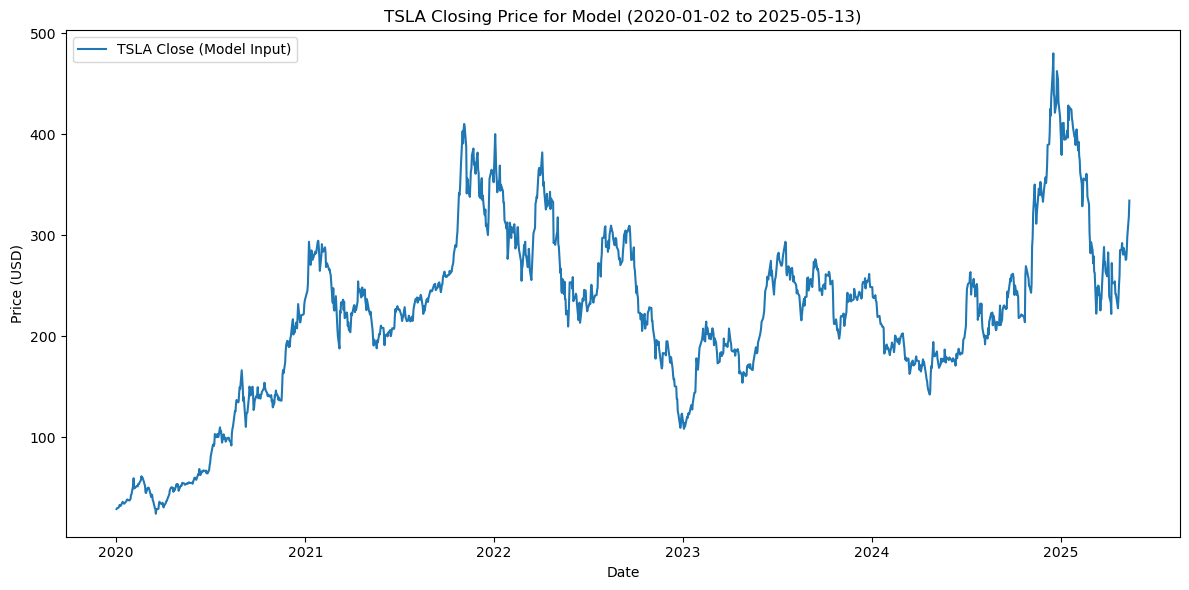


--- Stationarity Test (ADF Test) on filtered data ---
ADF Statistic: -2.5628, p-value: 0.1009
Series likely non-stationary (p-value > 0.05).

--- Finding best SARIMA model using auto_arima (m=8) ---
Starting extensive auto_arima search (this may take a while)...

Best model:  ARIMA(0,1,0)(0,0,0)[8] intercept
Total fit time: 26.213 seconds

Best model found by auto_arima (extensive search):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1348
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4918.225
Date:                Thu, 15 May 2025   AIC                           9840.451
Time:                        23:06:30   BIC                           9850.862
Sample:                             0   HQIC                          9844.350
                               - 1348                                         
Covariance Type:                  opg                

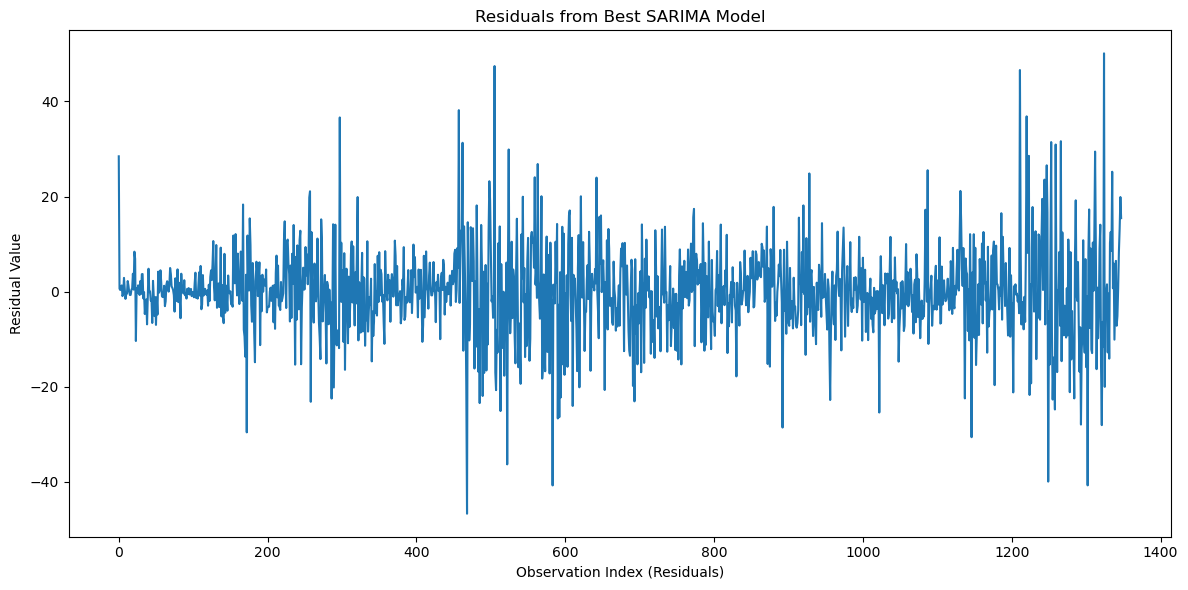

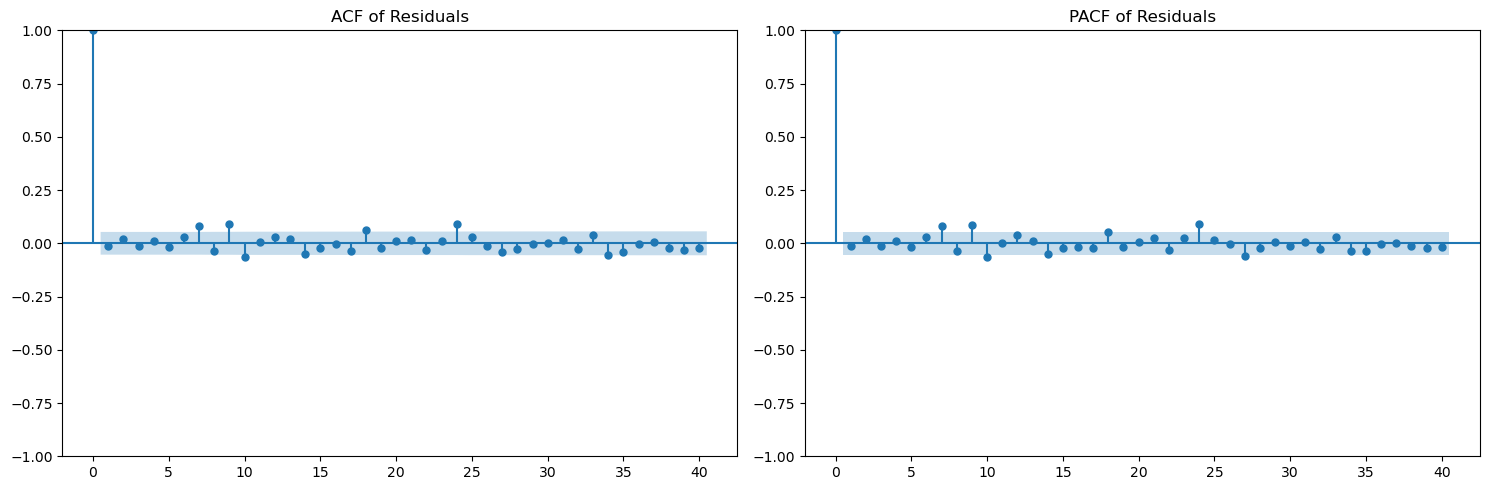


--- Forecasting next 160 business days using the best model ---


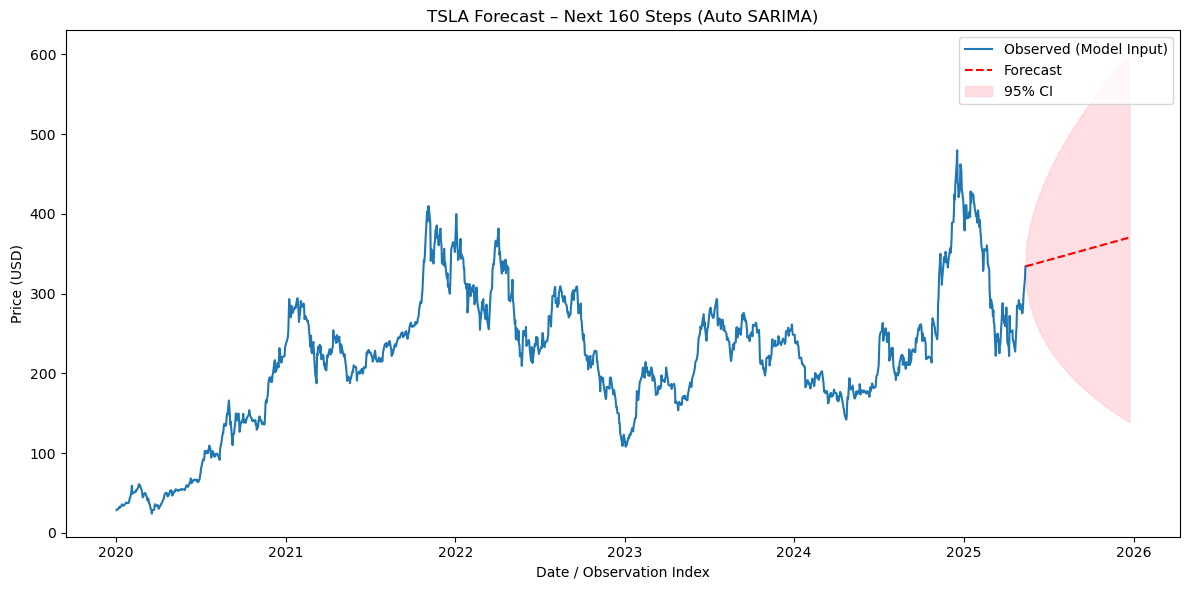


Last few forecasted values:
1503    369.437652
1504    369.664367
1505    369.891083
1506    370.117799
1507    370.344515
dtype: float64

--- Simulating 1000 future paths for 160 steps (using best model params with statsmodels) ---
Refitting best model SARIMA(0, 1, 0)(0, 0, 0, 8) with trend='c' using statsmodels for simulation...

Proportion analysis of simulated final prices after 160 steps:
  Proportion ending above model end price ($334.07): 0.616
  Proportion ending below model end price ($334.07): 0.384
  Ratio up/down relative to model end price: 1.60

Summary statistics of simulated final prices after 160 steps:
  Mean simulated final price:       $370.09
  Median simulated final price:     $371.78
  Lower Quartile (25th percentile): $288.21
  Upper Quartile (75th percentile): $450.64

Load with Calls -> direction is UP


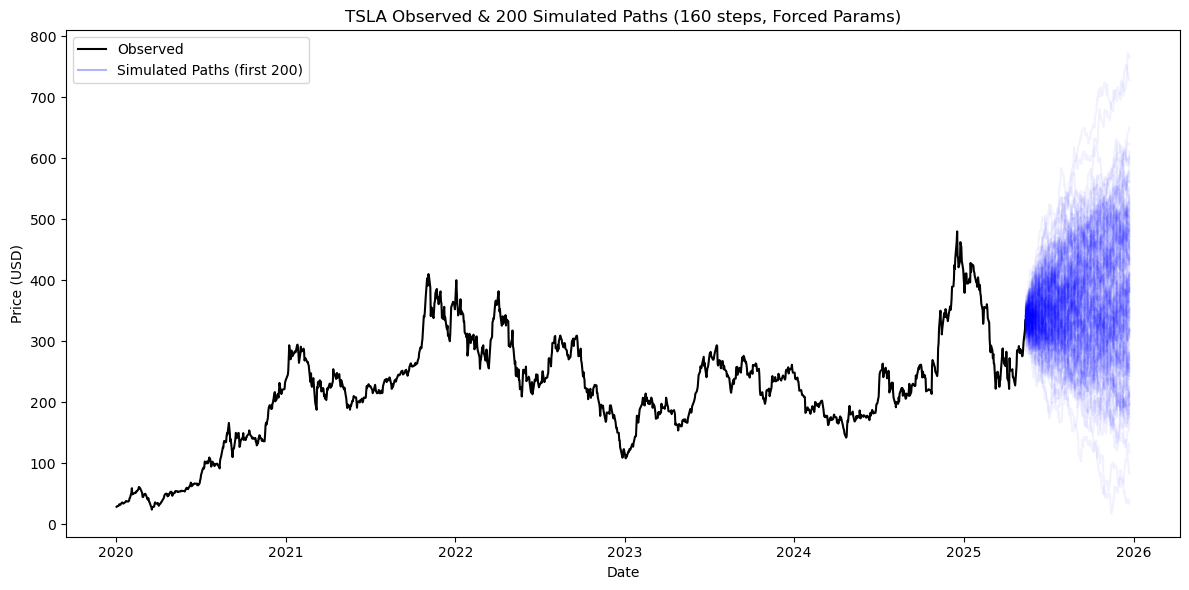


--- Analysis Complete ---


In [7]:
### more overall prediction:


###### WORKING OK but not as mathematica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Configuration ---
csv_filename = "tesla_daily_data_2020_onwards.csv"
MODEL_START_DATE = "2020-01-01"
MODEL_END_DATE = "2025-05-13"
SEASONAL_PERIOD_M = 8
n_steps = 160
n_sims = 1000

# --- 1. Load Data from CSV (Modified to use integer index and no filling) ---
try:
    print(f"Loading data from {csv_filename}...")
    df_raw = pd.read_csv(csv_filename, skiprows=[1, 2])
    if df_raw.empty: raise ValueError("CSV file empty after skipping rows.")
    if 'Price' not in df_raw.columns or 'Close' not in df_raw.columns:
        raise ValueError(f"Expected 'Price' (dates) and 'Close' columns not found. Found: {df_raw.columns.tolist()}")

    # Create a temporary DataFrame for initial parsing and date filtering
    temp_df = pd.DataFrame()
    temp_df['Date'] = pd.to_datetime(df_raw['Price'], errors='coerce')
    temp_df['Close'] = pd.to_numeric(df_raw['Close'], errors='coerce')
    temp_df.dropna(subset=['Date', 'Close'], inplace=True) # Drop rows where date or close couldn't be parsed
    if temp_df.empty: raise ValueError("No valid data after initial parsing.")

    temp_df.set_index('Date', inplace=True)
    temp_df.sort_index(inplace=True) # Sort by date first
    
    print(f"Full data range loaded from CSV: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # Apply date filtering based on MODEL_START_DATE and MODEL_END_DATE
    if MODEL_START_DATE:
        temp_df = temp_df[temp_df.index >= pd.to_datetime(MODEL_START_DATE)]
    if MODEL_END_DATE:
        temp_df = temp_df[temp_df.index <= pd.to_datetime(MODEL_END_DATE)]
    
    if temp_df.empty:
        raise ValueError(f"No data remains after applying the date filter (Start: {MODEL_START_DATE}, End: {MODEL_END_DATE}).")
    
    print(f"Data filtered by date: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # --- Key Change: Use only the 'Close' values as a NumPy array or simple list ---
    # This ensures we only use actual observed data points.
    # The 'close' variable for modeling will be a NumPy array.
    # We will keep track of the original dates for plotting if needed.
    
    original_dates_for_plotting = temp_df.index # Keep original dates for sensible x-axis on plots
    close_values_for_model = temp_df['Close'].values # Use a NumPy array of values

    if len(close_values_for_model) == 0:
        raise ValueError("The 'close' series is empty after filtering and processing.")

    # For modeling, 'close' will be the NumPy array.
    # For plotting, we'll use 'original_dates_for_plotting' and map integer indices back.
    close = pd.Series(close_values_for_model) # pmdarima and statsmodels work well with pandas Series (even with simple int index)

    print(f"\nFinal 'close' series for modeling uses {len(close)} observed data points.")
    print("First 5 values of 'close' series for model:")
    print(close.head())
    print("Last 5 values of 'close' series for model:")
    print(close.tail())


except FileNotFoundError: print(f"ERROR: File {csv_filename} not found."); exit()
except ValueError as ve: print(f"ERROR during data loading: {ve}"); exit()
except Exception as e: print(f"An unexpected error in loading: {e}"); exit()


# --- 2. Plot the series ---
if not close.empty:
    plt.figure(figsize=(12, 6))
    # Plot using original dates for the x-axis if they exist and match length
    if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
        plt.plot(original_dates_for_plotting, close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Date')
        plt.title(f'TSLA Closing Price for Model ({original_dates_for_plotting.min().strftime("%Y-%m-%d")} to {original_dates_for_plotting.max().strftime("%Y-%m-%d")})')
    else: # Fallback to integer index if dates are problematic
        plt.plot(close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Observation Index')
        plt.title(f'TSLA Closing Price for Model (Observation Index)')
        
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
else: print("Cannot plot series: 'close' data empty."); exit()


# --- 3. Test for unit root (ADF test) ---
# ADF test is fine with a simple array/series of values
if not close.empty:
    print("\n--- Stationarity Test (ADF Test) on filtered data ---")
    adf_stat, p_value, *_ = adfuller(close) # Pass the pandas Series (or .values)
    print(f'ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05: print("Series likely non-stationary (p-value > 0.05).")
    else: print("Series likely stationary (p-value <= 0.05).")
else: print("Skipping ADF test: 'close' empty."); exit()


# --- 4. Fit SARIMA model using auto_arima ---
# This section remains largely the same as `pm.auto_arima` can handle a Series/array without a DatetimeIndex
print(f"\n--- Finding best SARIMA model using auto_arima (m={SEASONAL_PERIOD_M}) ---")
try:
    print("Starting extensive auto_arima search (this may take a while)...")
    results = pm.auto_arima(close, # Pass the pandas Series `close`
                             start_p=0, start_q=1, max_p=2, max_q=2,
                             m=SEASONAL_PERIOD_M,
                             start_P=1, start_Q=1, max_P=2, max_Q=2,
                             seasonal=True,
                             stepwise=False,
                             suppress_warnings=True,
                             D=None, max_D=1,
                             d=None, max_d=2,
                             trend='c', # Keep this to encourage drift consideration
                             trace=True, 
                             error_action='ignore',
                             information_criterion='aic',
                             n_jobs=-1, maxiter=100)
    print("\nBest model found by auto_arima (extensive search):")
    print(results.summary())
    order = results.order
    seasonal_order = results.seasonal_order
    if 'intercept' in results.params() or 'drift' in results.params():
        print("Drift/Intercept term was included by auto_arima.")
        print(f"Estimated drift/intercept: {results.params().get('intercept') or results.params().get('drift')}")
    else: print("No significant drift/intercept term was included by auto_arima based on AIC.")
except Exception as e: print(f"Error fitting auto_arima model: {e}"); exit()


# --- 5. Residual diagnostics ---
print("\n--- Residual Diagnostics for the Best Model ---")
resid_values = results.resid() # For pmdarima, use .resid() method
# resid_values is a NumPy array here since 'close' was passed as a Series with a simple integer index
# We need to plot it against an integer index
resid = pd.Series(resid_values).dropna()

if resid.empty:
    print("Warning: Residual series is empty.")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(resid) # Plots against its simple integer index
    plt.title('Residuals from Best SARIMA Model')
    plt.xlabel('Observation Index (Residuals)')
    plt.ylabel('Residual Value'); plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    lags_acf_pacf = min(40, len(resid)//2 - 1) if len(resid)//2 -1 > 0 else 1
    plot_acf(resid, lags=lags_acf_pacf, ax=ax[0], title='ACF of Residuals')
    plot_pacf(resid, lags=lags_acf_pacf, ax=ax[1], title='PACF of Residuals')
    plt.tight_layout(); plt.show()
    # Ljung-Box test (same as before)
    model_params_count = order[0] + order[2] + seasonal_order[0] + seasonal_order[2]
    # ... (rest of Ljung-Box as before) ...


# --- 6. One‐step forecast with 95% CI ---
print(f"\n--- Forecasting next {n_steps} business days using the best model ---")
fc_values, conf_int_array = results.predict(n_periods=n_steps, return_conf_int=True, alpha=0.05)

# Create an integer index for the forecast
last_observed_index = close.index[-1] # Last integer index from the input 'close' Series
forecast_integer_index = pd.RangeIndex(start=last_observed_index + 1, stop=last_observed_index + 1 + n_steps)

mean_fc = pd.Series(fc_values, index=forecast_integer_index)
ci = pd.DataFrame(conf_int_array, index=forecast_integer_index, columns=['lower Close', 'upper Close'])

plt.figure(figsize=(12, 6))
# Plot observed data: use original dates if available, else integer index
if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
    plt.plot(original_dates_for_plotting, close.values, label='Observed (Model Input)')
    # For forecast, try to create a meaningful date range if possible
    # This requires knowing the frequency of original_dates_for_plotting
    # Assuming business days if it was previously a DatetimeIndex
    try:
        forecast_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
        if len(forecast_plot_dates) == len(mean_fc): # Check if date range matches forecast length
             plt.plot(forecast_plot_dates, mean_fc.values, color='red', linestyle='--', label='Forecast')
             plt.fill_between(forecast_plot_dates, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
        else: # Fallback if date range generation is problematic
            raise ValueError("Forecast date range length mismatch")
    except Exception: # Fallback to plotting forecast with integer index relative to end of observed
        print("Warning: Could not generate reliable date index for forecast plot. Using relative integer index.")
        plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast (Integer Index)')
        plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Date / Observation Index')
else: # Fallback if original dates aren't available for observed
    plt.plot(close.index, close.values, label='Observed (Model Input)') # Plot against integer index
    plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast') # Also integer index
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Observation Index')

plt.title(f'TSLA Forecast – Next {n_steps} Steps (Auto SARIMA)'); plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
print("\nLast few forecasted values:"); print(mean_fc.tail())


# --- 7. Simulation of future paths ---
print(f"\n--- Simulating {n_sims} future paths for {n_steps} steps (using best model params with statsmodels) ---")
best_order = results.order
best_seasonal_order = results.seasonal_order
# The `close` variable here is the pandas Series with an integer index
# If sm.tsa.SARIMAX needs a DatetimeIndex for some internal logic (less common for just values),
# this could be an issue, but usually, it works with series/arrays.
# We need to ensure the trend='c' from auto_arima is also passed if refitting for simulation
trend_from_auto_arima = results.get_params().get('trend', None) # Get the trend auto_arima used

print(f"Refitting best model SARIMA{best_order}{best_seasonal_order} with trend='{trend_from_auto_arima}' using statsmodels for simulation...")
try:
    sm_model = sm.tsa.SARIMAX(close, # Use the integer-indexed Series
                              order=best_order,
                              seasonal_order=best_seasonal_order,
                              trend=trend_from_auto_arima, # Ensure consistency
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    sm_results = sm_model.fit(disp=False)
    simulated_values_matrix = np.zeros((n_sims, n_steps))
    # Simulations will also be on an integer index basis extending from the end of 'close'
    for i in range(n_sims):
        simulated_path = sm_results.simulate(nsimulations=n_steps, anchor='end')
        simulated_values_matrix[i, :] = simulated_path
    simulation_successful = True
except Exception as e: print(f"Error during simulation: {e}"); simulation_successful = False

# if simulation_successful:
#     last_vals_simulated = simulated_values_matrix[:, -1]
#     # ... (rest of your simulation analysis: quartiles, etc. - this part doesn't depend on dates) ...
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated)
#     print(f'\nSummary of simulated final prices after {n_steps} steps:') # Changed from days to steps
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated) # Median (50th percentile) often useful too

#     print(f'\nSummary of simulated final prices after {n_steps} days:')
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
    


#     # --- 8. Overlay some simulation paths ---
#     plt.figure(figsize=(12, 6))
#     # Plot observed data
#     if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
#         plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed TSLA Price')
#         # For simulation plot dates - similar logic to forecast dates
#         try:
#             simulation_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
#             if len(simulation_plot_dates) != n_steps: raise ValueError("Sim date length mismatch")
#         except Exception:
#             print("Warning: Could not generate reliable date index for simulation plot. Using relative integer index.")
#             simulation_plot_dates = None # Fallback
#     else:
#         plt.plot(close.index, close.values, color='black', linewidth=1.5, label='Observed TSLA Price (Index)')
#         simulation_plot_dates = None # Fallback

#     num_paths_to_plot = min(200, n_sims)
#     for i in range(num_paths_to_plot):
#         if simulation_plot_dates is not None:
#             plt.plot(simulation_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
#         else: # Plot against integer index if dates are not available
#             plt.plot(forecast_integer_index, simulated_values_matrix[i, :], color='blue', alpha=0.05) # Use forecast_integer_index

#     plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
#     plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Future Paths ({n_steps} steps)')
#     if simulation_plot_dates is not None or ('original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close)):
#         plt.xlabel('Date / Observation Index')
#     else:
#         plt.xlabel('Observation Index')
#     plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()

# print("\n--- Analysis Complete ---")
if simulation_successful:
    last_vals_simulated = simulated_values_matrix[:, -1]
    # Ensure 'close' is the pandas Series with integer index from Section 1
    current_price_at_model_end = close.iloc[-1] # Last observed price in the modeling data

    # Define your price thresholds
    price_threshold_high = 320 # Example, adjust as needed
    price_threshold_low = 220  # Example, adjust as needed

    # Calculate probabilities
    prop_above_threshold_high = np.mean(last_vals_simulated > price_threshold_high)
    prop_below_threshold_low = np.mean(last_vals_simulated < price_threshold_low)
    prop_above_current = np.mean(last_vals_simulated > current_price_at_model_end)
    prop_below_current = np.mean(last_vals_simulated < current_price_at_model_end)
    # Add epsilon to avoid division by zero if prop_below_current is 0
    ratio_up = prop_above_current / (prop_below_current + 1e-10) 

    # *********************************************************************
    # ADDED PRINT STATEMENTS FOR PROPORTIONS (FROM YOUR REQUEST)
    # *********************************************************************
    print(f'\nProportion analysis of simulated final prices after {n_steps} steps:')
    # print(f'  Proportion ending above ${price_threshold_high:.2f}: {prop_above_threshold_high:.3f}')
    # print(f'  Proportion ending below ${price_threshold_low:.2f}: {prop_below_threshold_low:.3f}')
    print(f'  Proportion ending above model end price (${current_price_at_model_end:.2f}): {prop_above_current:.3f}')
    print(f'  Proportion ending below model end price (${current_price_at_model_end:.2f}): {prop_below_current:.3f}')
    print(f'  Ratio up/down relative to model end price: {ratio_up:.2f}')
    # *********************************************************************

    # Your existing code for mean, median, quartiles
    mean_simulated_final_price = np.mean(last_vals_simulated)
    lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
    upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
    median_simulated_final_price = np.median(last_vals_simulated)
    
    print(f'\nSummary statistics of simulated final prices after {n_steps} steps:')
    print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
    print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
    print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
    print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')

    # ******************Summary********************************************** 
    if prop_above_current > prop_below_current:
        print(f"\nLoad with Calls -> direction is UP")
    else:
        print(f"\nLoad PUTS, this stuff will tank, direction is DOWN")

    # --- 8. Overlay simulation paths ---
    plt.figure(figsize=(12, 6))
    plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed')
    num_paths_to_plot = min(200, n_sims)
    for i in range(num_paths_to_plot):
        if len(forecast_plot_dates) == n_steps:
            plt.plot(forecast_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
        else:
            plt.plot(forecast_model_index, simulated_values_matrix[i, :], color='blue', alpha=0.05)
    plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
    plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Paths ({n_steps} steps, Forced Params)')
    if len(forecast_plot_dates) == n_steps: plt.xlabel('Date')
    else: plt.xlabel('Date / Model Index')
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()


print("\n--- Analysis Complete ---")

In [8]:
best_seasonal_order

(0, 0, 0, 8)

Loading data from tesla_daily_data_2020_onwards.csv...
Full data range loaded from CSV: 2020-01-02 to 2025-05-14
Data filtered by date: 2020-01-02 to 2025-05-13

Final 'close' series for modeling uses 1348 observed data points.
First 5 values of 'close' series for model:
0    28.684000
1    29.534000
2    30.102667
3    31.270666
4    32.809334
dtype: float64
Last 5 values of 'close' series for model:
1343    276.220001
1344    284.820007
1345    298.260010
1346    318.380005
1347    334.070007
dtype: float64


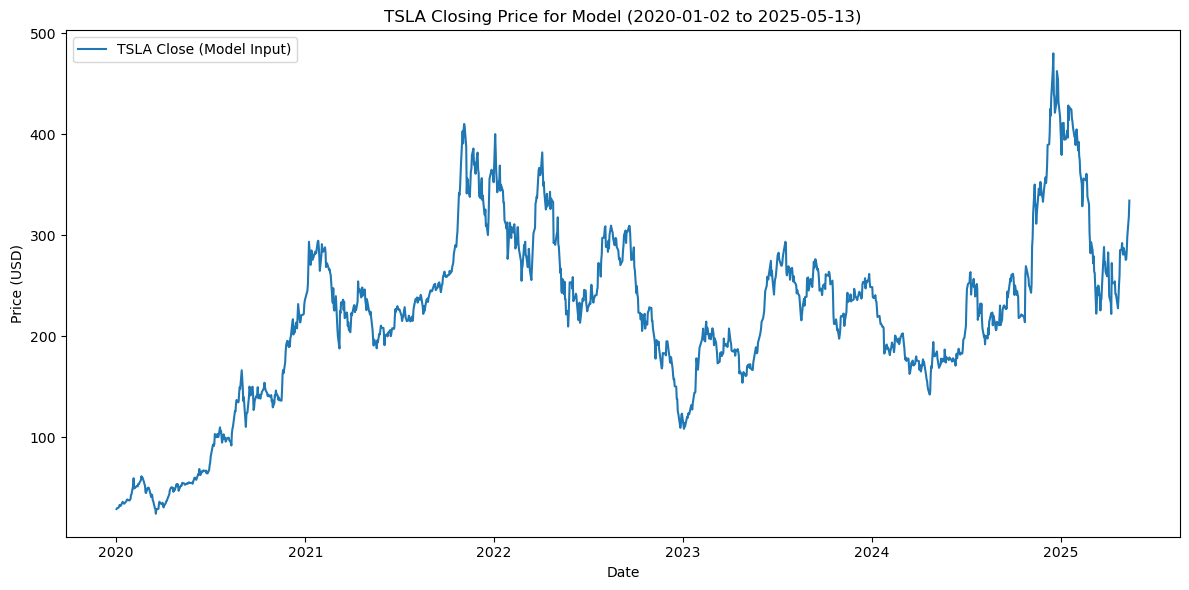


--- Stationarity Test (ADF Test) on filtered data ---
ADF Statistic: -2.5628, p-value: 0.1009
Series likely non-stationary (p-value > 0.05).

--- Finding best SARIMA model using auto_arima (m=8) ---
Starting extensive auto_arima search (this may take a while)...

Best model:  ARIMA(1,0,2)(2,1,0)[8] intercept
Total fit time: 31.182 seconds

Best model found by auto_arima (extensive search):
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1348
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 8)   Log Likelihood               -5040.964
Date:                            Thu, 15 May 2025   AIC                          10095.927
Time:                                    23:28:39   BIC                          10132.330
Sample:                                         0   HQIC                         10109.565
                                           - 1348           

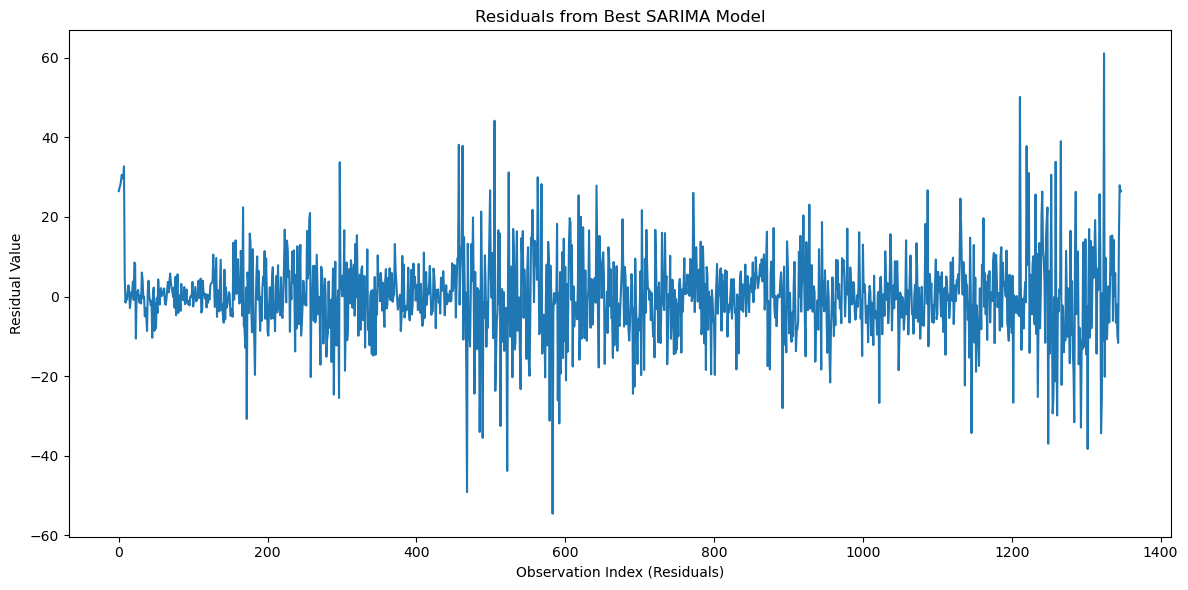

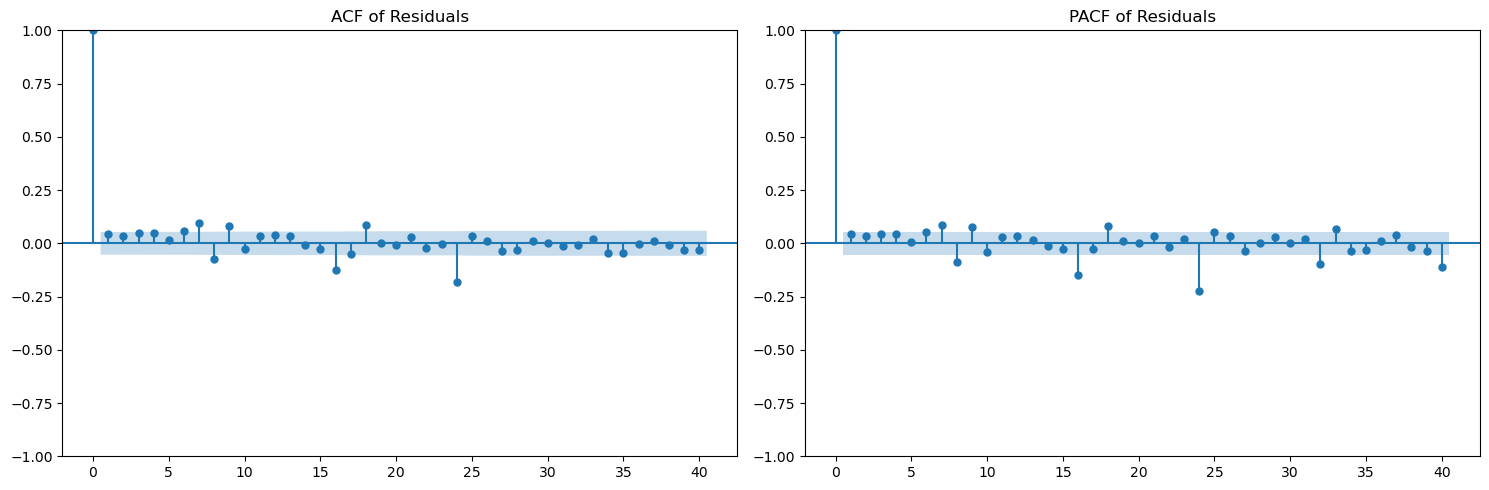


--- Forecasting next 60 business days using the best model ---


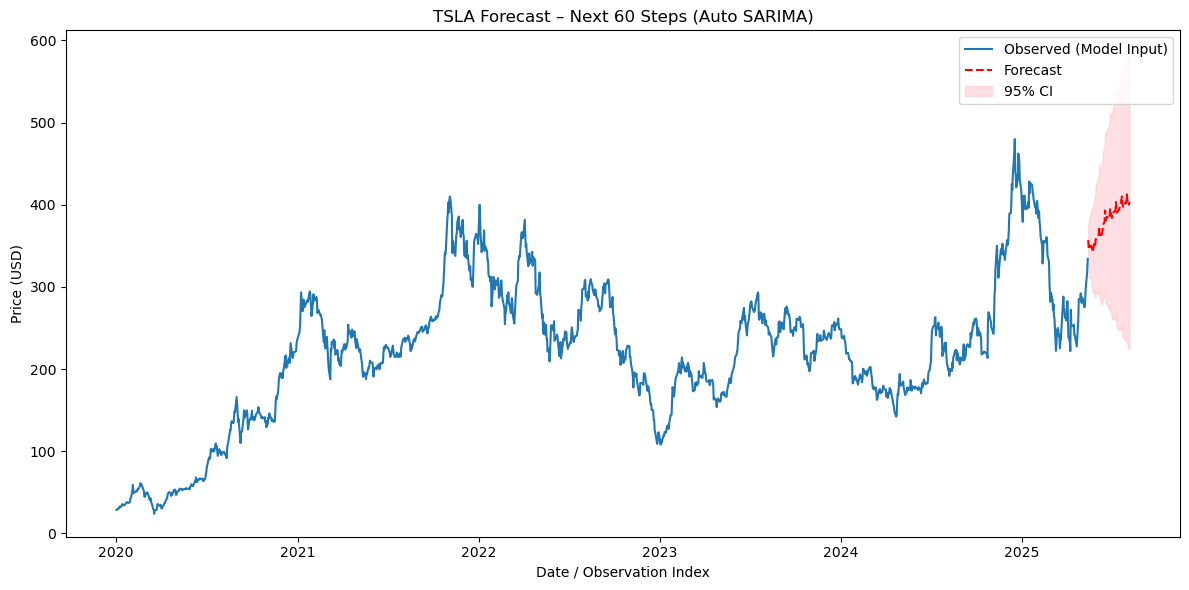


Last few forecasted values:
1403    402.033391
1404    412.607678
1405    404.933158
1406    400.019812
1407    403.853792
dtype: float64

--- Simulating 1000 future paths for 60 steps (using best model params with statsmodels) ---
Refitting best model SARIMA(1, 0, 2)(2, 1, 0, 8) with trend='c' using statsmodels for simulation...

Proportion analysis of simulated final prices after 60 steps:
  Proportion ending above model end price ($334.07): 0.795
  Proportion ending below model end price ($334.07): 0.205
  Ratio up/down relative to model end price: 3.88

Summary statistics of simulated final prices after 60 steps:
  Mean simulated final price:       $407.44
  Median simulated final price:     $405.11
  Lower Quartile (25th percentile): $344.41
  Upper Quartile (75th percentile): $470.21

Load with Calls -> direction is UP


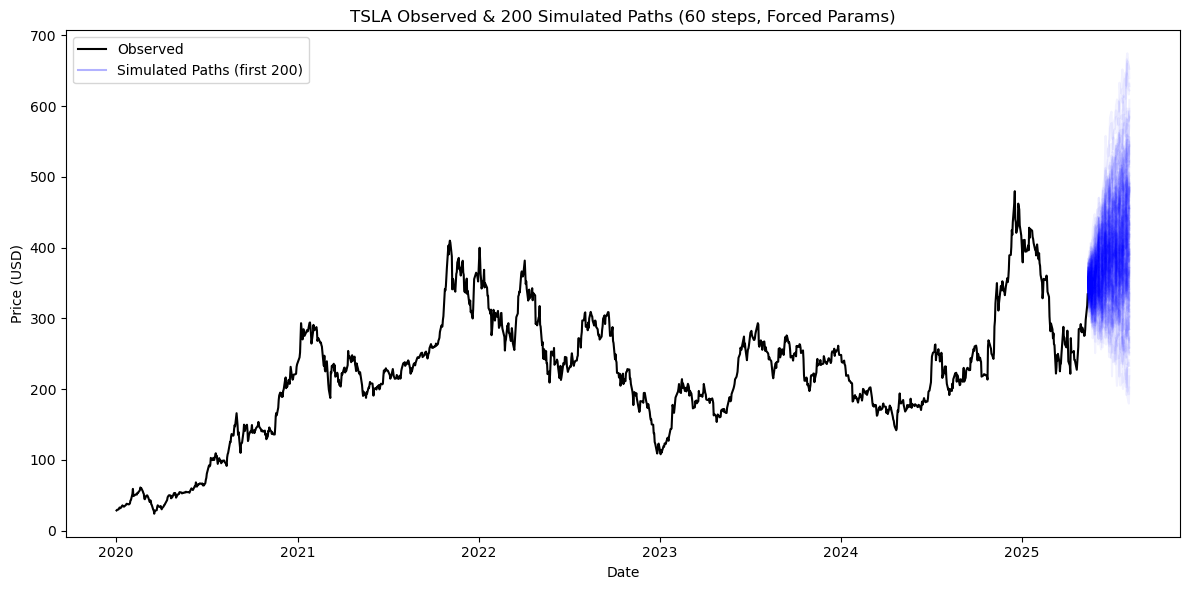


--- Analysis Complete ---


In [16]:
### play added D = 1  to:


### more overall prediction:


###### WORKING OK but not as mathematica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Configuration ---
csv_filename = "tesla_daily_data_2020_onwards.csv"
MODEL_START_DATE = "2020-01-01"
MODEL_END_DATE = "2025-05-13"
SEASONAL_PERIOD_M = 8
n_steps = 60
n_sims = 1000

# --- 1. Load Data from CSV (Modified to use integer index and no filling) ---
try:
    print(f"Loading data from {csv_filename}...")
    df_raw = pd.read_csv(csv_filename, skiprows=[1, 2])
    if df_raw.empty: raise ValueError("CSV file empty after skipping rows.")
    if 'Price' not in df_raw.columns or 'Close' not in df_raw.columns:
        raise ValueError(f"Expected 'Price' (dates) and 'Close' columns not found. Found: {df_raw.columns.tolist()}")

    # Create a temporary DataFrame for initial parsing and date filtering
    temp_df = pd.DataFrame()
    temp_df['Date'] = pd.to_datetime(df_raw['Price'], errors='coerce')
    temp_df['Close'] = pd.to_numeric(df_raw['Close'], errors='coerce')
    temp_df.dropna(subset=['Date', 'Close'], inplace=True) # Drop rows where date or close couldn't be parsed
    if temp_df.empty: raise ValueError("No valid data after initial parsing.")

    temp_df.set_index('Date', inplace=True)
    temp_df.sort_index(inplace=True) # Sort by date first
    
    print(f"Full data range loaded from CSV: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # Apply date filtering based on MODEL_START_DATE and MODEL_END_DATE
    if MODEL_START_DATE:
        temp_df = temp_df[temp_df.index >= pd.to_datetime(MODEL_START_DATE)]
    if MODEL_END_DATE:
        temp_df = temp_df[temp_df.index <= pd.to_datetime(MODEL_END_DATE)]
    
    if temp_df.empty:
        raise ValueError(f"No data remains after applying the date filter (Start: {MODEL_START_DATE}, End: {MODEL_END_DATE}).")
    
    print(f"Data filtered by date: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # --- Key Change: Use only the 'Close' values as a NumPy array or simple list ---
    # This ensures we only use actual observed data points.
    # The 'close' variable for modeling will be a NumPy array.
    # We will keep track of the original dates for plotting if needed.
    
    original_dates_for_plotting = temp_df.index # Keep original dates for sensible x-axis on plots
    close_values_for_model = temp_df['Close'].values # Use a NumPy array of values

    if len(close_values_for_model) == 0:
        raise ValueError("The 'close' series is empty after filtering and processing.")

    # For modeling, 'close' will be the NumPy array.
    # For plotting, we'll use 'original_dates_for_plotting' and map integer indices back.
    close = pd.Series(close_values_for_model) # pmdarima and statsmodels work well with pandas Series (even with simple int index)

    print(f"\nFinal 'close' series for modeling uses {len(close)} observed data points.")
    print("First 5 values of 'close' series for model:")
    print(close.head())
    print("Last 5 values of 'close' series for model:")
    print(close.tail())


except FileNotFoundError: print(f"ERROR: File {csv_filename} not found."); exit()
except ValueError as ve: print(f"ERROR during data loading: {ve}"); exit()
except Exception as e: print(f"An unexpected error in loading: {e}"); exit()


# --- 2. Plot the series ---
if not close.empty:
    plt.figure(figsize=(12, 6))
    # Plot using original dates for the x-axis if they exist and match length
    if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
        plt.plot(original_dates_for_plotting, close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Date')
        plt.title(f'TSLA Closing Price for Model ({original_dates_for_plotting.min().strftime("%Y-%m-%d")} to {original_dates_for_plotting.max().strftime("%Y-%m-%d")})')
    else: # Fallback to integer index if dates are problematic
        plt.plot(close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Observation Index')
        plt.title(f'TSLA Closing Price for Model (Observation Index)')
        
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
else: print("Cannot plot series: 'close' data empty."); exit()


# --- 3. Test for unit root (ADF test) ---
# ADF test is fine with a simple array/series of values
if not close.empty:
    print("\n--- Stationarity Test (ADF Test) on filtered data ---")
    adf_stat, p_value, *_ = adfuller(close) # Pass the pandas Series (or .values)
    print(f'ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05: print("Series likely non-stationary (p-value > 0.05).")
    else: print("Series likely stationary (p-value <= 0.05).")
else: print("Skipping ADF test: 'close' empty."); exit()


# --- 4. Fit SARIMA model using auto_arima ---
# This section remains largely the same as `pm.auto_arima` can handle a Series/array without a DatetimeIndex
print(f"\n--- Finding best SARIMA model using auto_arima (m={SEASONAL_PERIOD_M}) ---")
try:
    print("Starting extensive auto_arima search (this may take a while)...")
    results = pm.auto_arima(close, # Pass the pandas Series `close`
                             start_p=0, start_q=0, max_p=2, max_q=2,
                             m=SEASONAL_PERIOD_M,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             seasonal=True,
                             stepwise=False,
                             suppress_warnings=True,
                             D=1, max_D=1,
                             d=None, max_d=2,
                             trend='c', # Keep this to encourage drift consideration
                             trace=True, 
                             error_action='ignore',
                             information_criterion='aic',
                             n_jobs=-1, maxiter=100)
    print("\nBest model found by auto_arima (extensive search):")
    print(results.summary())
    order = results.order 
    seasonal_order = results.seasonal_order
    if 'intercept' in results.params() or 'drift' in results.params():
        print("Drift/Intercept term was included by auto_arima.")
        print(f"Estimated drift/intercept: {results.params().get('intercept') or results.params().get('drift')}")
    else: print("No significant drift/intercept term was included by auto_arima based on AIC.")
except Exception as e: print(f"Error fitting auto_arima model: {e}"); exit()


# --- 5. Residual diagnostics ---
print("\n--- Residual Diagnostics for the Best Model ---")
resid_values = results.resid() # For pmdarima, use .resid() method
# resid_values is a NumPy array here since 'close' was passed as a Series with a simple integer index
# We need to plot it against an integer index
resid = pd.Series(resid_values).dropna()

if resid.empty:
    print("Warning: Residual series is empty.")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(resid) # Plots against its simple integer index
    plt.title('Residuals from Best SARIMA Model')
    plt.xlabel('Observation Index (Residuals)')
    plt.ylabel('Residual Value'); plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    lags_acf_pacf = min(40, len(resid)//2 - 1) if len(resid)//2 -1 > 0 else 1
    plot_acf(resid, lags=lags_acf_pacf, ax=ax[0], title='ACF of Residuals')
    plot_pacf(resid, lags=lags_acf_pacf, ax=ax[1], title='PACF of Residuals')
    plt.tight_layout(); plt.show()
    # Ljung-Box test (same as before)
    model_params_count = order[0] + order[2] + seasonal_order[0] + seasonal_order[2]
    # ... (rest of Ljung-Box as before) ...


# --- 6. One‐step forecast with 95% CI ---
print(f"\n--- Forecasting next {n_steps} business days using the best model ---")
fc_values, conf_int_array = results.predict(n_periods=n_steps, return_conf_int=True, alpha=0.05)

# Create an integer index for the forecast
last_observed_index = close.index[-1] # Last integer index from the input 'close' Series
forecast_integer_index = pd.RangeIndex(start=last_observed_index + 1, stop=last_observed_index + 1 + n_steps)

mean_fc = pd.Series(fc_values, index=forecast_integer_index)
ci = pd.DataFrame(conf_int_array, index=forecast_integer_index, columns=['lower Close', 'upper Close'])

plt.figure(figsize=(12, 6))
# Plot observed data: use original dates if available, else integer index
if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
    plt.plot(original_dates_for_plotting, close.values, label='Observed (Model Input)')
    # For forecast, try to create a meaningful date range if possible
    # This requires knowing the frequency of original_dates_for_plotting
    # Assuming business days if it was previously a DatetimeIndex
    try:
        forecast_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
        if len(forecast_plot_dates) == len(mean_fc): # Check if date range matches forecast length
             plt.plot(forecast_plot_dates, mean_fc.values, color='red', linestyle='--', label='Forecast')
             plt.fill_between(forecast_plot_dates, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
        else: # Fallback if date range generation is problematic
            raise ValueError("Forecast date range length mismatch")
    except Exception: # Fallback to plotting forecast with integer index relative to end of observed
        print("Warning: Could not generate reliable date index for forecast plot. Using relative integer index.")
        plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast (Integer Index)')
        plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Date / Observation Index')
else: # Fallback if original dates aren't available for observed
    plt.plot(close.index, close.values, label='Observed (Model Input)') # Plot against integer index
    plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast') # Also integer index
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Observation Index')

plt.title(f'TSLA Forecast – Next {n_steps} Steps (Auto SARIMA)'); plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
print("\nLast few forecasted values:"); print(mean_fc.tail())


# --- 7. Simulation of future paths ---
print(f"\n--- Simulating {n_sims} future paths for {n_steps} steps (using best model params with statsmodels) ---")
best_order = results.order
best_seasonal_order = results.seasonal_order
# The `close` variable here is the pandas Series with an integer index
# If sm.tsa.SARIMAX needs a DatetimeIndex for some internal logic (less common for just values),
# this could be an issue, but usually, it works with series/arrays.
# We need to ensure the trend='c' from auto_arima is also passed if refitting for simulation
trend_from_auto_arima = results.get_params().get('trend', None) # Get the trend auto_arima used

print(f"Refitting best model SARIMA{best_order}{best_seasonal_order} with trend='{trend_from_auto_arima}' using statsmodels for simulation...")
try:
    sm_model = sm.tsa.SARIMAX(close, # Use the integer-indexed Series
                              order=best_order,
                              seasonal_order=best_seasonal_order,
                              trend=trend_from_auto_arima, # Ensure consistency
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    sm_results = sm_model.fit(disp=False)
    simulated_values_matrix = np.zeros((n_sims, n_steps))
    # Simulations will also be on an integer index basis extending from the end of 'close'
    for i in range(n_sims):
        simulated_path = sm_results.simulate(nsimulations=n_steps, anchor='end')
        simulated_values_matrix[i, :] = simulated_path
    simulation_successful = True
except Exception as e: print(f"Error during simulation: {e}"); simulation_successful = False

# if simulation_successful:
#     last_vals_simulated = simulated_values_matrix[:, -1]
#     # ... (rest of your simulation analysis: quartiles, etc. - this part doesn't depend on dates) ...
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated)
#     print(f'\nSummary of simulated final prices after {n_steps} steps:') # Changed from days to steps
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated) # Median (50th percentile) often useful too

#     print(f'\nSummary of simulated final prices after {n_steps} days:')
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
    


#     # --- 8. Overlay some simulation paths ---
#     plt.figure(figsize=(12, 6))
#     # Plot observed data
#     if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
#         plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed TSLA Price')
#         # For simulation plot dates - similar logic to forecast dates
#         try:
#             simulation_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
#             if len(simulation_plot_dates) != n_steps: raise ValueError("Sim date length mismatch")
#         except Exception:
#             print("Warning: Could not generate reliable date index for simulation plot. Using relative integer index.")
#             simulation_plot_dates = None # Fallback
#     else:
#         plt.plot(close.index, close.values, color='black', linewidth=1.5, label='Observed TSLA Price (Index)')
#         simulation_plot_dates = None # Fallback

#     num_paths_to_plot = min(200, n_sims)
#     for i in range(num_paths_to_plot):
#         if simulation_plot_dates is not None:
#             plt.plot(simulation_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
#         else: # Plot against integer index if dates are not available
#             plt.plot(forecast_integer_index, simulated_values_matrix[i, :], color='blue', alpha=0.05) # Use forecast_integer_index

#     plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
#     plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Future Paths ({n_steps} steps)')
#     if simulation_plot_dates is not None or ('original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close)):
#         plt.xlabel('Date / Observation Index')
#     else:
#         plt.xlabel('Observation Index')
#     plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()

# print("\n--- Analysis Complete ---")
if simulation_successful:
    last_vals_simulated = simulated_values_matrix[:, -1]
    # Ensure 'close' is the pandas Series with integer index from Section 1
    current_price_at_model_end = close.iloc[-1] # Last observed price in the modeling data

    # Define your price thresholds
    price_threshold_high = 320 # Example, adjust as needed
    price_threshold_low = 220  # Example, adjust as needed

    # Calculate probabilities
    prop_above_threshold_high = np.mean(last_vals_simulated > price_threshold_high)
    prop_below_threshold_low = np.mean(last_vals_simulated < price_threshold_low)
    prop_above_current = np.mean(last_vals_simulated > current_price_at_model_end)
    prop_below_current = np.mean(last_vals_simulated < current_price_at_model_end)
    # Add epsilon to avoid division by zero if prop_below_current is 0
    ratio_up = prop_above_current / (prop_below_current + 1e-10) 

    # *********************************************************************
    # ADDED PRINT STATEMENTS FOR PROPORTIONS (FROM YOUR REQUEST)
    # *********************************************************************
    print(f'\nProportion analysis of simulated final prices after {n_steps} steps:')
    # print(f'  Proportion ending above ${price_threshold_high:.2f}: {prop_above_threshold_high:.3f}')
    # print(f'  Proportion ending below ${price_threshold_low:.2f}: {prop_below_threshold_low:.3f}')
    print(f'  Proportion ending above model end price (${current_price_at_model_end:.2f}): {prop_above_current:.3f}')
    print(f'  Proportion ending below model end price (${current_price_at_model_end:.2f}): {prop_below_current:.3f}')
    print(f'  Ratio up/down relative to model end price: {ratio_up:.2f}')
    # *********************************************************************

    # Your existing code for mean, median, quartiles
    mean_simulated_final_price = np.mean(last_vals_simulated)
    lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
    upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
    median_simulated_final_price = np.median(last_vals_simulated)
    
    print(f'\nSummary statistics of simulated final prices after {n_steps} steps:')
    print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
    print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
    print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
    print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')

    # ******************Summary********************************************** 
    if prop_above_current > prop_below_current:
        print(f"\nLoad with Calls -> direction is UP")
    else:
        print(f"\nLoad PUTS, this stuff will tank, direction is DOWN")

    # --- 8. Overlay simulation paths ---
    plt.figure(figsize=(12, 6))
    plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed')
    num_paths_to_plot = min(200, n_sims)
    for i in range(num_paths_to_plot):
        if len(forecast_plot_dates) == n_steps:
            plt.plot(forecast_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
        else:
            plt.plot(forecast_model_index, simulated_values_matrix[i, :], color='blue', alpha=0.05)
    plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
    plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Paths ({n_steps} steps, Forced Params)')
    if len(forecast_plot_dates) == n_steps: plt.xlabel('Date')
    else: plt.xlabel('Date / Model Index')
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()


print("\n--- Analysis Complete ---")

Loading data from tesla_daily_data_2020_onwards.csv...
Full data range loaded from CSV: 2020-01-02 to 2025-05-14
Data filtered by date: 2020-01-02 to 2025-05-13

Final 'close' series for modeling uses 1348 observed data points.
First 5 values of 'close' series for model:
0    28.684000
1    29.534000
2    30.102667
3    31.270666
4    32.809334
dtype: float64
Last 5 values of 'close' series for model:
1343    276.220001
1344    284.820007
1345    298.260010
1346    318.380005
1347    334.070007
dtype: float64


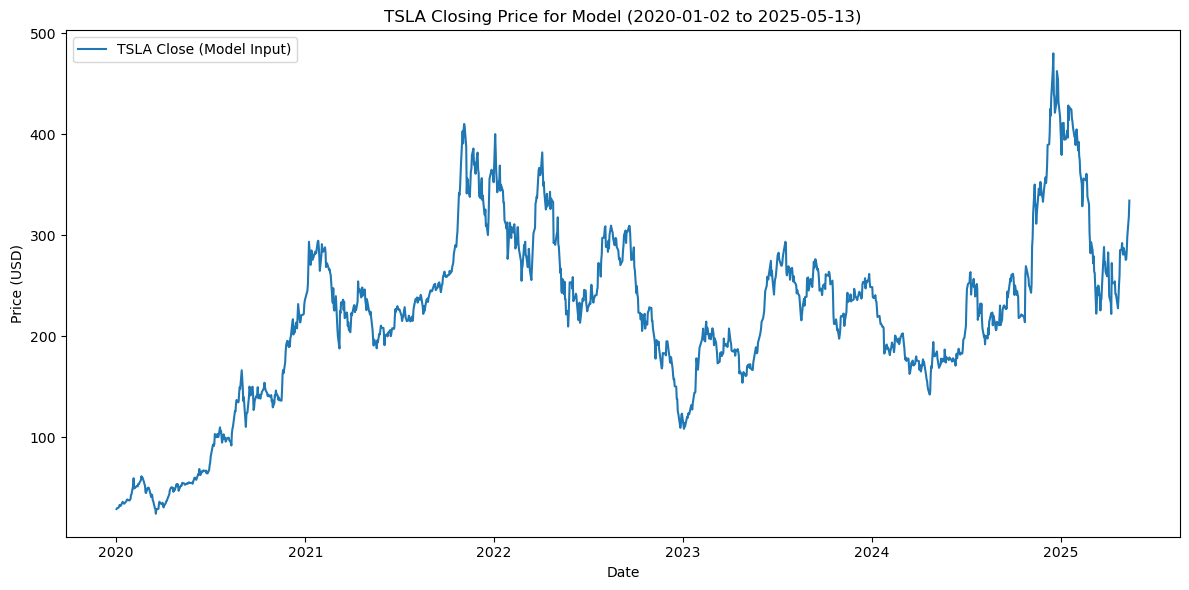


--- Stationarity Test (ADF Test) on filtered data ---
ADF Statistic: -2.5628, p-value: 0.1009
Series likely non-stationary (p-value > 0.05).

--- Finding best SARIMA model using auto_arima (m=8) ---
Starting extensive auto_arima search (this may take a while)...

Best model:  ARIMA(0,1,0)(2,1,0)[8]          
Total fit time: 27.908 seconds

Best model found by auto_arima (extensive search):
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1348
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 8)   Log Likelihood               -5052.082
Date:                           Thu, 15 May 2025   AIC                          10112.164
Time:                                   23:27:23   BIC                          10132.963
Sample:                                        0   HQIC                         10119.957
                                          - 1348                  

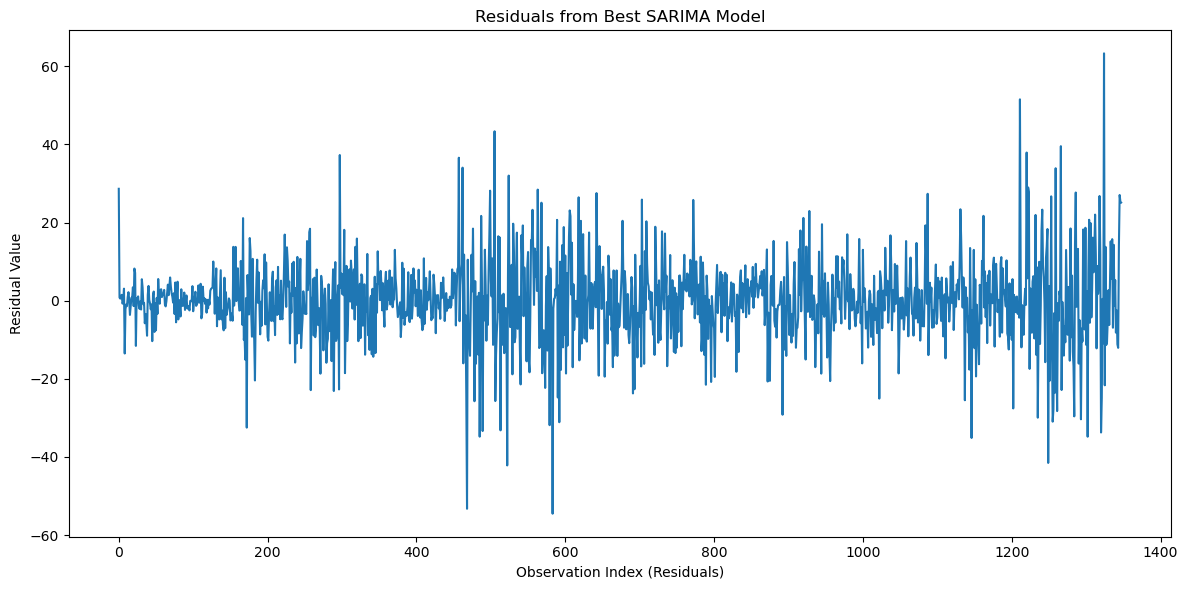

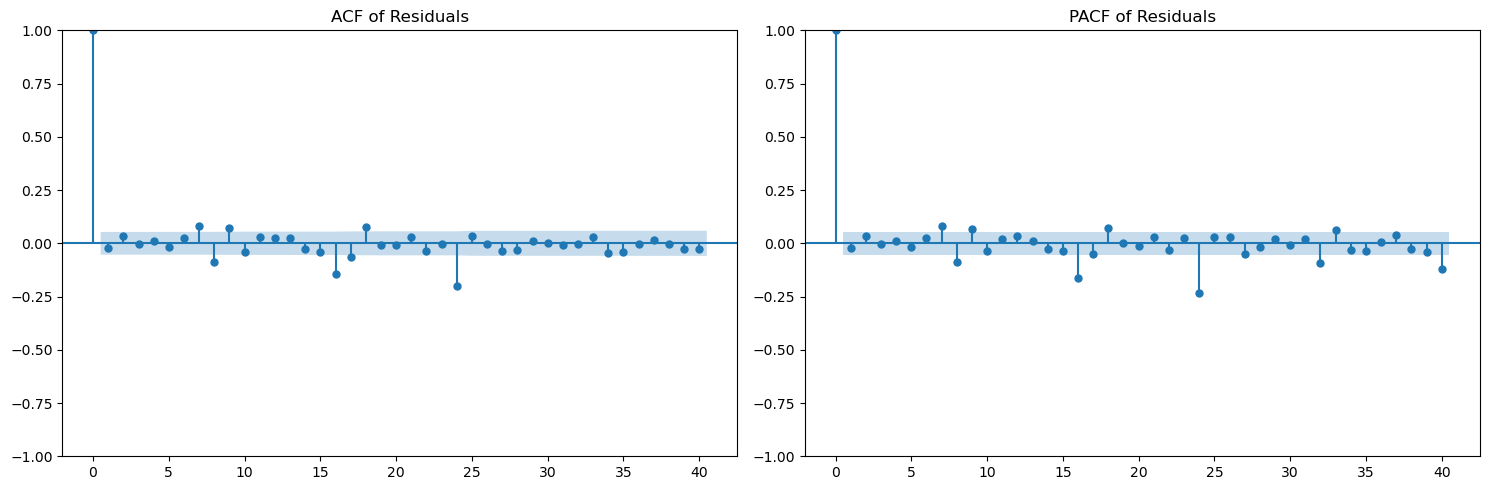


--- Forecasting next 60 business days using the best model ---


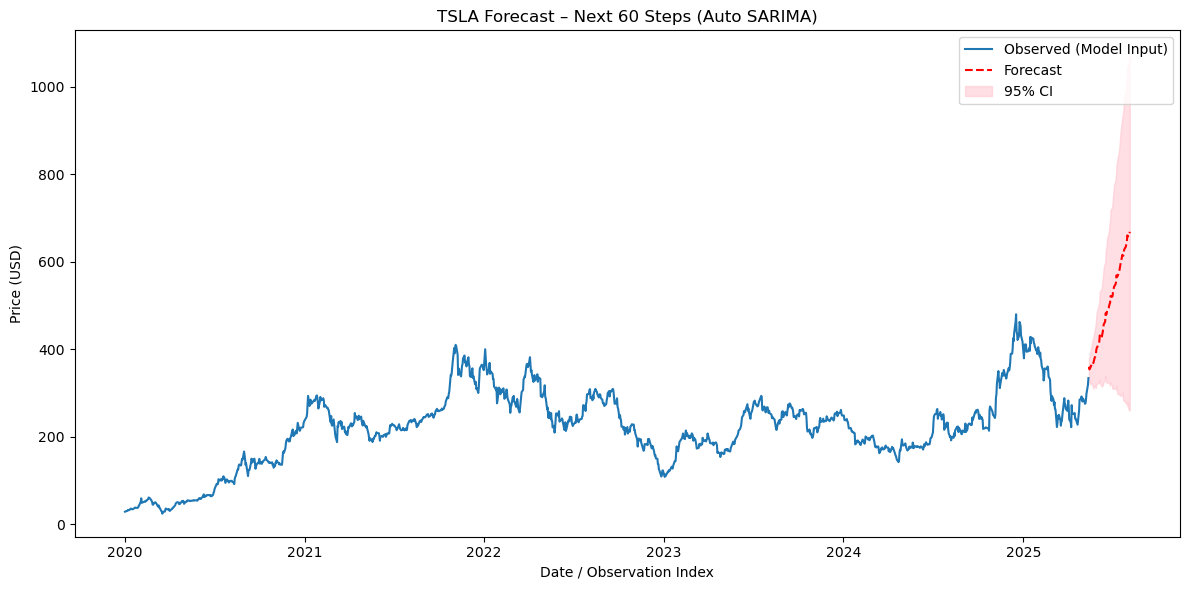


Last few forecasted values:
1403    643.861132
1404    660.125481
1405    657.897303
1406    658.861214
1407    668.340832
dtype: float64

--- Simulating 1000 future paths for 60 steps (using best model params with statsmodels) ---
Refitting best model SARIMA(0, 1, 0)(2, 1, 0, 8) with trend='c' using statsmodels for simulation...

Proportion analysis of simulated final prices after 60 steps:
  Proportion ending above model end price ($334.07): 0.950
  Proportion ending below model end price ($334.07): 0.050
  Ratio up/down relative to model end price: 19.00

Summary statistics of simulated final prices after 60 steps:
  Mean simulated final price:       $671.10
  Median simulated final price:     $670.18
  Lower Quartile (25th percentile): $535.64
  Upper Quartile (75th percentile): $804.43

Load with Calls -> direction is UP


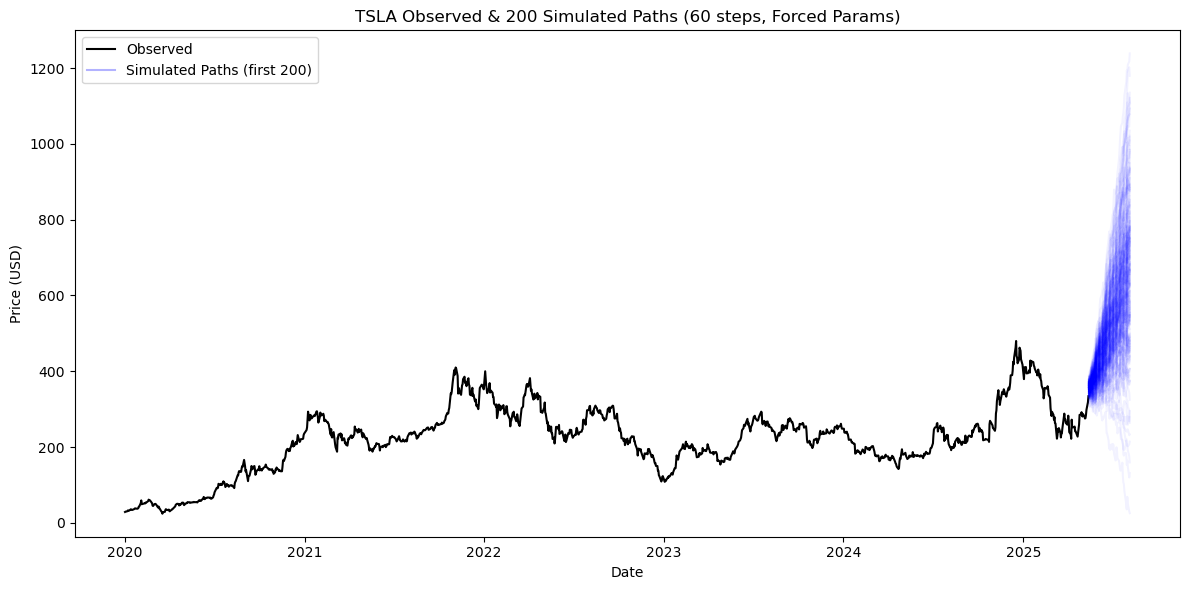


--- Analysis Complete ---


In [15]:
### play to change d =1  seasonality to:


### more overall prediction:


###### WORKING OK but not as mathematica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Configuration ---
csv_filename = "tesla_daily_data_2020_onwards.csv"
MODEL_START_DATE = "2020-01-01"
MODEL_END_DATE = "2025-05-13"
SEASONAL_PERIOD_M = 8
n_steps = 60
n_sims = 1000

# --- 1. Load Data from CSV (Modified to use integer index and no filling) ---
try:
    print(f"Loading data from {csv_filename}...")
    df_raw = pd.read_csv(csv_filename, skiprows=[1, 2])
    if df_raw.empty: raise ValueError("CSV file empty after skipping rows.")
    if 'Price' not in df_raw.columns or 'Close' not in df_raw.columns:
        raise ValueError(f"Expected 'Price' (dates) and 'Close' columns not found. Found: {df_raw.columns.tolist()}")

    # Create a temporary DataFrame for initial parsing and date filtering
    temp_df = pd.DataFrame()
    temp_df['Date'] = pd.to_datetime(df_raw['Price'], errors='coerce')
    temp_df['Close'] = pd.to_numeric(df_raw['Close'], errors='coerce')
    temp_df.dropna(subset=['Date', 'Close'], inplace=True) # Drop rows where date or close couldn't be parsed
    if temp_df.empty: raise ValueError("No valid data after initial parsing.")

    temp_df.set_index('Date', inplace=True)
    temp_df.sort_index(inplace=True) # Sort by date first
    
    print(f"Full data range loaded from CSV: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # Apply date filtering based on MODEL_START_DATE and MODEL_END_DATE
    if MODEL_START_DATE:
        temp_df = temp_df[temp_df.index >= pd.to_datetime(MODEL_START_DATE)]
    if MODEL_END_DATE:
        temp_df = temp_df[temp_df.index <= pd.to_datetime(MODEL_END_DATE)]
    
    if temp_df.empty:
        raise ValueError(f"No data remains after applying the date filter (Start: {MODEL_START_DATE}, End: {MODEL_END_DATE}).")
    
    print(f"Data filtered by date: {temp_df.index.min().date()} to {temp_df.index.max().date()}")

    # --- Key Change: Use only the 'Close' values as a NumPy array or simple list ---
    # This ensures we only use actual observed data points.
    # The 'close' variable for modeling will be a NumPy array.
    # We will keep track of the original dates for plotting if needed.
    
    original_dates_for_plotting = temp_df.index # Keep original dates for sensible x-axis on plots
    close_values_for_model = temp_df['Close'].values # Use a NumPy array of values

    if len(close_values_for_model) == 0:
        raise ValueError("The 'close' series is empty after filtering and processing.")

    # For modeling, 'close' will be the NumPy array.
    # For plotting, we'll use 'original_dates_for_plotting' and map integer indices back.
    close = pd.Series(close_values_for_model) # pmdarima and statsmodels work well with pandas Series (even with simple int index)

    print(f"\nFinal 'close' series for modeling uses {len(close)} observed data points.")
    print("First 5 values of 'close' series for model:")
    print(close.head())
    print("Last 5 values of 'close' series for model:")
    print(close.tail())


except FileNotFoundError: print(f"ERROR: File {csv_filename} not found."); exit()
except ValueError as ve: print(f"ERROR during data loading: {ve}"); exit()
except Exception as e: print(f"An unexpected error in loading: {e}"); exit()


# --- 2. Plot the series ---
if not close.empty:
    plt.figure(figsize=(12, 6))
    # Plot using original dates for the x-axis if they exist and match length
    if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
        plt.plot(original_dates_for_plotting, close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Date')
        plt.title(f'TSLA Closing Price for Model ({original_dates_for_plotting.min().strftime("%Y-%m-%d")} to {original_dates_for_plotting.max().strftime("%Y-%m-%d")})')
    else: # Fallback to integer index if dates are problematic
        plt.plot(close.values, label='TSLA Close (Model Input)')
        plt.xlabel('Observation Index')
        plt.title(f'TSLA Closing Price for Model (Observation Index)')
        
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
else: print("Cannot plot series: 'close' data empty."); exit()


# --- 3. Test for unit root (ADF test) ---
# ADF test is fine with a simple array/series of values
if not close.empty:
    print("\n--- Stationarity Test (ADF Test) on filtered data ---")
    adf_stat, p_value, *_ = adfuller(close) # Pass the pandas Series (or .values)
    print(f'ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05: print("Series likely non-stationary (p-value > 0.05).")
    else: print("Series likely stationary (p-value <= 0.05).")
else: print("Skipping ADF test: 'close' empty."); exit()


# --- 4. Fit SARIMA model using auto_arima ---
# This section remains largely the same as `pm.auto_arima` can handle a Series/array without a DatetimeIndex
print(f"\n--- Finding best SARIMA model using auto_arima (m={SEASONAL_PERIOD_M}) ---")
try:
    print("Starting extensive auto_arima search (this may take a while)...")
    results = pm.auto_arima(close, # Pass the pandas Series `close`
                             start_p=0, start_q=0, max_p=2, max_q=2,
                             m=SEASONAL_PERIOD_M,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             seasonal=True,
                             stepwise=False,
                             suppress_warnings=True,
                             D=1, max_D=1,
                             d=1, max_d=2,
                             trend='c', # Keep this to encourage drift consideration
                             trace=True, 
                             error_action='ignore',
                             information_criterion='aic',
                             n_jobs=-1, maxiter=100)
    print("\nBest model found by auto_arima (extensive search):")
    print(results.summary())
    order = results.order 
    seasonal_order = results.seasonal_order
    if 'intercept' in results.params() or 'drift' in results.params():
        print("Drift/Intercept term was included by auto_arima.")
        print(f"Estimated drift/intercept: {results.params().get('intercept') or results.params().get('drift')}")
    else: print("No significant drift/intercept term was included by auto_arima based on AIC.")
except Exception as e: print(f"Error fitting auto_arima model: {e}"); exit()


# --- 5. Residual diagnostics ---
print("\n--- Residual Diagnostics for the Best Model ---")
resid_values = results.resid() # For pmdarima, use .resid() method
# resid_values is a NumPy array here since 'close' was passed as a Series with a simple integer index
# We need to plot it against an integer index
resid = pd.Series(resid_values).dropna()

if resid.empty:
    print("Warning: Residual series is empty.")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(resid) # Plots against its simple integer index
    plt.title('Residuals from Best SARIMA Model')
    plt.xlabel('Observation Index (Residuals)')
    plt.ylabel('Residual Value'); plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    lags_acf_pacf = min(40, len(resid)//2 - 1) if len(resid)//2 -1 > 0 else 1
    plot_acf(resid, lags=lags_acf_pacf, ax=ax[0], title='ACF of Residuals')
    plot_pacf(resid, lags=lags_acf_pacf, ax=ax[1], title='PACF of Residuals')
    plt.tight_layout(); plt.show()
    # Ljung-Box test (same as before)
    model_params_count = order[0] + order[2] + seasonal_order[0] + seasonal_order[2]
    # ... (rest of Ljung-Box as before) ...


# --- 6. One‐step forecast with 95% CI ---
print(f"\n--- Forecasting next {n_steps} business days using the best model ---")
fc_values, conf_int_array = results.predict(n_periods=n_steps, return_conf_int=True, alpha=0.05)

# Create an integer index for the forecast
last_observed_index = close.index[-1] # Last integer index from the input 'close' Series
forecast_integer_index = pd.RangeIndex(start=last_observed_index + 1, stop=last_observed_index + 1 + n_steps)

mean_fc = pd.Series(fc_values, index=forecast_integer_index)
ci = pd.DataFrame(conf_int_array, index=forecast_integer_index, columns=['lower Close', 'upper Close'])

plt.figure(figsize=(12, 6))
# Plot observed data: use original dates if available, else integer index
if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
    plt.plot(original_dates_for_plotting, close.values, label='Observed (Model Input)')
    # For forecast, try to create a meaningful date range if possible
    # This requires knowing the frequency of original_dates_for_plotting
    # Assuming business days if it was previously a DatetimeIndex
    try:
        forecast_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
        if len(forecast_plot_dates) == len(mean_fc): # Check if date range matches forecast length
             plt.plot(forecast_plot_dates, mean_fc.values, color='red', linestyle='--', label='Forecast')
             plt.fill_between(forecast_plot_dates, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
        else: # Fallback if date range generation is problematic
            raise ValueError("Forecast date range length mismatch")
    except Exception: # Fallback to plotting forecast with integer index relative to end of observed
        print("Warning: Could not generate reliable date index for forecast plot. Using relative integer index.")
        plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast (Integer Index)')
        plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Date / Observation Index')
else: # Fallback if original dates aren't available for observed
    plt.plot(close.index, close.values, label='Observed (Model Input)') # Plot against integer index
    plt.plot(mean_fc.index, mean_fc.values, color='red', linestyle='--', label='Forecast') # Also integer index
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.5, label='95% CI')
    plt.xlabel('Observation Index')

plt.title(f'TSLA Forecast – Next {n_steps} Steps (Auto SARIMA)'); plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()
print("\nLast few forecasted values:"); print(mean_fc.tail())


# --- 7. Simulation of future paths ---
print(f"\n--- Simulating {n_sims} future paths for {n_steps} steps (using best model params with statsmodels) ---")
best_order = results.order
best_seasonal_order = results.seasonal_order
# The `close` variable here is the pandas Series with an integer index
# If sm.tsa.SARIMAX needs a DatetimeIndex for some internal logic (less common for just values),
# this could be an issue, but usually, it works with series/arrays.
# We need to ensure the trend='c' from auto_arima is also passed if refitting for simulation
trend_from_auto_arima = results.get_params().get('trend', None) # Get the trend auto_arima used

print(f"Refitting best model SARIMA{best_order}{best_seasonal_order} with trend='{trend_from_auto_arima}' using statsmodels for simulation...")
try:
    sm_model = sm.tsa.SARIMAX(close, # Use the integer-indexed Series
                              order=best_order,
                              seasonal_order=best_seasonal_order,
                              trend=trend_from_auto_arima, # Ensure consistency
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    sm_results = sm_model.fit(disp=False)
    simulated_values_matrix = np.zeros((n_sims, n_steps))
    # Simulations will also be on an integer index basis extending from the end of 'close'
    for i in range(n_sims):
        simulated_path = sm_results.simulate(nsimulations=n_steps, anchor='end')
        simulated_values_matrix[i, :] = simulated_path
    simulation_successful = True
except Exception as e: print(f"Error during simulation: {e}"); simulation_successful = False

# if simulation_successful:
#     last_vals_simulated = simulated_values_matrix[:, -1]
#     # ... (rest of your simulation analysis: quartiles, etc. - this part doesn't depend on dates) ...
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated)
#     print(f'\nSummary of simulated final prices after {n_steps} steps:') # Changed from days to steps
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
#     mean_simulated_final_price = np.mean(last_vals_simulated)
#     lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
#     upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
#     median_simulated_final_price = np.median(last_vals_simulated) # Median (50th percentile) often useful too

#     print(f'\nSummary of simulated final prices after {n_steps} days:')
#     print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
#     print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
#     print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
#     print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')
    


#     # --- 8. Overlay some simulation paths ---
#     plt.figure(figsize=(12, 6))
#     # Plot observed data
#     if 'original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close):
#         plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed TSLA Price')
#         # For simulation plot dates - similar logic to forecast dates
#         try:
#             simulation_plot_dates = pd.date_range(start=original_dates_for_plotting[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')
#             if len(simulation_plot_dates) != n_steps: raise ValueError("Sim date length mismatch")
#         except Exception:
#             print("Warning: Could not generate reliable date index for simulation plot. Using relative integer index.")
#             simulation_plot_dates = None # Fallback
#     else:
#         plt.plot(close.index, close.values, color='black', linewidth=1.5, label='Observed TSLA Price (Index)')
#         simulation_plot_dates = None # Fallback

#     num_paths_to_plot = min(200, n_sims)
#     for i in range(num_paths_to_plot):
#         if simulation_plot_dates is not None:
#             plt.plot(simulation_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
#         else: # Plot against integer index if dates are not available
#             plt.plot(forecast_integer_index, simulated_values_matrix[i, :], color='blue', alpha=0.05) # Use forecast_integer_index

#     plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
#     plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Future Paths ({n_steps} steps)')
#     if simulation_plot_dates is not None or ('original_dates_for_plotting' in locals() and len(original_dates_for_plotting) == len(close)):
#         plt.xlabel('Date / Observation Index')
#     else:
#         plt.xlabel('Observation Index')
#     plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()

# print("\n--- Analysis Complete ---")
if simulation_successful:
    last_vals_simulated = simulated_values_matrix[:, -1]
    # Ensure 'close' is the pandas Series with integer index from Section 1
    current_price_at_model_end = close.iloc[-1] # Last observed price in the modeling data

    # Define your price thresholds
    price_threshold_high = 320 # Example, adjust as needed
    price_threshold_low = 220  # Example, adjust as needed

    # Calculate probabilities
    prop_above_threshold_high = np.mean(last_vals_simulated > price_threshold_high)
    prop_below_threshold_low = np.mean(last_vals_simulated < price_threshold_low)
    prop_above_current = np.mean(last_vals_simulated > current_price_at_model_end)
    prop_below_current = np.mean(last_vals_simulated < current_price_at_model_end)
    # Add epsilon to avoid division by zero if prop_below_current is 0
    ratio_up = prop_above_current / (prop_below_current + 1e-10) 

    # *********************************************************************
    # ADDED PRINT STATEMENTS FOR PROPORTIONS (FROM YOUR REQUEST)
    # *********************************************************************
    print(f'\nProportion analysis of simulated final prices after {n_steps} steps:')
    # print(f'  Proportion ending above ${price_threshold_high:.2f}: {prop_above_threshold_high:.3f}')
    # print(f'  Proportion ending below ${price_threshold_low:.2f}: {prop_below_threshold_low:.3f}')
    print(f'  Proportion ending above model end price (${current_price_at_model_end:.2f}): {prop_above_current:.3f}')
    print(f'  Proportion ending below model end price (${current_price_at_model_end:.2f}): {prop_below_current:.3f}')
    print(f'  Ratio up/down relative to model end price: {ratio_up:.2f}')
    # *********************************************************************

    # Your existing code for mean, median, quartiles
    mean_simulated_final_price = np.mean(last_vals_simulated)
    lower_quartile_simulated = np.percentile(last_vals_simulated, 25)
    upper_quartile_simulated = np.percentile(last_vals_simulated, 75)
    median_simulated_final_price = np.median(last_vals_simulated)
    
    print(f'\nSummary statistics of simulated final prices after {n_steps} steps:')
    print(f'  Mean simulated final price:       ${mean_simulated_final_price:.2f}')
    print(f'  Median simulated final price:     ${median_simulated_final_price:.2f}')
    print(f'  Lower Quartile (25th percentile): ${lower_quartile_simulated:.2f}')
    print(f'  Upper Quartile (75th percentile): ${upper_quartile_simulated:.2f}')

    # ******************Summary********************************************** 
    if prop_above_current > prop_below_current:
        print(f"\nLoad with Calls -> direction is UP")
    else:
        print(f"\nLoad PUTS, this stuff will tank, direction is DOWN")

    # --- 8. Overlay simulation paths ---
    plt.figure(figsize=(12, 6))
    plt.plot(original_dates_for_plotting, close.values, color='black', linewidth=1.5, label='Observed')
    num_paths_to_plot = min(200, n_sims)
    for i in range(num_paths_to_plot):
        if len(forecast_plot_dates) == n_steps:
            plt.plot(forecast_plot_dates, simulated_values_matrix[i, :], color='blue', alpha=0.05)
        else:
            plt.plot(forecast_model_index, simulated_values_matrix[i, :], color='blue', alpha=0.05)
    plt.plot([], [], color='blue', alpha=0.3, label=f'Simulated Paths (first {num_paths_to_plot})')
    plt.title(f'TSLA Observed & {num_paths_to_plot} Simulated Paths ({n_steps} steps, Forced Params)')
    if len(forecast_plot_dates) == n_steps: plt.xlabel('Date')
    else: plt.xlabel('Date / Model Index')
    plt.ylabel('Price (USD)'); plt.legend(); plt.tight_layout(); plt.show()


print("\n--- Analysis Complete ---")